# Quantifying Christie: A Computational Analysis of Hercule Poirot and Miss Marple

## Introduction

Dame Agatha Christie, lovingly referred to as "The Queen of Mystery," is one of the most prolific and esteemed mystery writers in recent history. Having produced 66 detective novels and 14 short story collections in addition to the world’s longest-running play, *The Mousetrap*, she is outsold only by the Bible and Shakespeare ("About Agatha Christie"). Generations have cherished Christie's works for their ingenious plots, quirky characters, and famous last-minute twists.

Christie's most famous detective was born out of her boredom at her work in a medicine dispensary during World War I, spurred by a bet made with her sister, Madge ("About Agatha Christie"). Hercule Poirot, a meticulous, eccentric former Belgian police officer, entered the world in Christie's debut novel, *The Mysterious Affair at Styles*, sporting his foreign appearance and peculiar mannerisms. In that case and over 32 others, Poirot utilizes his "little grey cells," "order and method," and "*la psychologie*" to come to the solution (Bargainnier 59).

Any discussion of Christie's detectives would be remiss without the mention of Miss Jane Marple, a sharp and cunning spinster residing in the sleepy but occasionally sinister fictional village of St. Mary Meade. Known for comparing suspects to her village acquaintances and drawing sleuthing inspiration from poetry, Miss Marple is the "homely" detective. She can crack a case through cups of tea, literature, and gossip, and does so over 12 novels and several short stories ("About Agatha Christie").

This project seeks to characterize and compare Christie's two most famous sleuths using computational techniques. First, the language used to describe each detective is examined. Then, the individual quirks each detective exhibits during sleuthing are reproduced quantitatively. Finally, the relationships between each detective and the suspects of their cases are linguistically analyzed and compared in an effort to spot the murderer.

### Table of Contents
* [Importing Libraries, Tools, and Data](#Importing-Libraries,-Tools,-and-Data)
* [Comparing Features of the Detectives](#Comparing-Features-of-the-Detectives)
  * [Overview](#Overview)
  * [Getting Actions of Each Detective](#Getting-Actions-of-Each-Detective)
  * [Sentiments](#Sentiments)
    * [Sentiment Helper Function](#Sentiment-Helper-Function)
    * [Sentiment Analysis](#Sentiment-Analysis)
* [Detective-Specific Features](#Detective-Specific-Features)
  * [Hercule Poirot's Clue Indicators](#Hercule-Poirot's-Clue-Indicators)
    * [Clue Indicator Helper Functions](#Clue-Indicator-Helper-Functions)
    * [Detecting Clues](#Detecting-Clues)
  * [Miss Marple's Allusions](#Miss-Marple's-Allusions)
    * [Allusion Helper Function](#Allusion-Helper-Function)
    * [Finding Allusions](#Finding-Allusions)
* [Emulating Sleuthing](#Emulating-Sleuthing)
  * [Clues that Interest the Detectives](#Clues-that-Interest-the-Detectives)
    * [Object Clue Helper Functions](#Object-Clue-Helper-Functions)
    * [Finding Object Clues](#Finding-Object-Clues)
  * [Feature Helper Functions](#Feature-Helper-Functions)
  * [Feature Calculation Functions](#Feature-Calculation-Functions)
  * [Create and Plot Suspect Data](#Create-and-Plot-Suspect-Data)
* [Conclusion](#Conclusion)
* [Works Cited](#Works-Cited)

## Importing Libraries, Tools, and Data

In [1]:
import nltk
import re
import math
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer, SentimentAnalyzer
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
text_info = eval(open("text_info.txt").read()) # Load dictionary saved as string in text_info.txt to have access to necessary data
for fileid in text_info:
    text_info[fileid]["text"] = open(fileid, encoding="utf-8").read() # Add full texts of files to each file subdictionary
# Print preview of dictionary
for item in text_info["the_mysterious_affair_at_styles.md"]:
    print(item + ":")
    if item == "text":
        print(text_info["the_mysterious_affair_at_styles.md"][item][:200]) # Don't print out the entire text
    else:
        print(text_info["the_mysterious_affair_at_styles.md"][item]) # Print full value of other keys
    print() # Print an empty line to separate from output of next item

detective:
{'Hercule Poirot': ['Poirot']}

victim:
{'Emily Inglethorp': ['Emily', 'Mrs. Inglethorp']}

murderer:
{'Alfred Inglethorp': ['Alfred', 'Mr. Inglethorp'], 'Evelyn Howard': ['Evelyn', 'Howard']}

suspects:
{'Alfred Inglethorp': ['Alfred', 'Mr. Inglethorp'], 'John Cavendish': ['John'], 'Mary Cavendish': ['Mary', 'Mrs. Cavendish', 'madame'], 'Lawrence Cavendish': ['Lawrence'], 'Evelyn Howard': ['Evelyn', 'Howard'], 'Cynthia Murdoch': ['Cynthia', 'Murdoch']}

text:
## CHAPTER I

The intense interest aroused in the public by what was known at the time as 'The Styles Case' has now somewhat subsided. Nevertheless, in view of the world-wide notoriety which attended 



The identities and many names of the detective, victim(s), suspects, and murderer(s) of each novel is stored in the file `text_info.txt`. Those values are then joined by the novels' full texts in a nested dictionary. This data structure was chosen due to the ease of associating different characters through the key-value organizational system.

In [4]:
# List of fileids for each detective, for easy access
poirot_fileids = ["the_mysterious_affair_at_styles.md", "death_on_the_nile.md", "the_abc_murders.md", "after_the_funeral.md", "five_little_pigs.md", "the_murder_on_the_links.md", "lord_edgware_dies.md", "evil_under_the_sun.md", "cat_among_the_pigeons.md", "peril_at_end_house.md"]
marple_fileids = ["the_murder_at_the_vicarage.md", "the_body_in_the_library.md", "the_moving_finger.md", "a_murder_is_announced.md", "a_pocket_full_of_rye.md", "450_from_paddington.md", "the_mirror_crackd_from_side_to_side.md", "a_caribbean_mystery.md", "nemesis.md", "sleeping_murder.md"]

The corpus used in this analysis consists of 20 novels, 10 for each detective as assigned above. Each text has been cropped to exclude the chapters that reveal the murderer(s) to avoid giving away the solution for the last section of this project.

## Comparing Features of the Detectives

### Overview

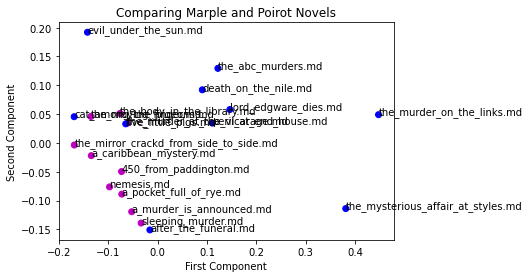

In [5]:
all_titles = [fileid for fileid in text_info] # Get list of all novel titles to eventually use as index
# Get list of "m"s and "c"s representing colors to use when plotting based on whether this is a Marple novel or a Poirot novel
colors = ["m" if fileid in marple_fileids else "b" for fileid in all_titles]
raw_texts = [text_info[fileid]["text"] for fileid in text_info] # Get list of full texts of novels
# Clean by removing proper nouns and chapter titles (which are both capitalized) and stopwords (only necessary for stylometry)
cleaned_texts = [" ".join([word for word in text.split() if word.islower()]) for text in raw_texts]
tfidf_vectorizer = TfidfVectorizer(min_df=0.50, max_features=400, use_idf=False, stop_words="english") # Create vectorizer
word_freqs = tfidf_vectorizer.fit_transform(cleaned_texts).todense() # Use to find word frequencies of 400 words for each text
pca = PCA(n_components=2) # Create PCA object for component reduction
freqs_reduced = pca.fit_transform(word_freqs) # Reduce word frequencies to 2 components for visualization purposes
# Create new dataframe to hold reduced components
df = pd.DataFrame(freqs_reduced, 
             columns=["First Component", "Second Component"],
             index=all_titles
            )
plt.scatter(x=df["First Component"], y=df["Second Component"], c=colors) # Create color-coded scatterplot to differentiate between the cases of each detective
plt.title("Comparing Marple and Poirot Novels")
plt.xlabel("First Component")
plt.ylabel("Second Component")
for i in range(df.shape[0]):
    plt.text(df["First Component"][i], df["Second Component"][i], df.index[i]) # Add fileid label for each point

Here, the Marple novels are labeled in purple and the Poirot novels are in blue. The plot is made using frequencies of 400 words that appear in at least half the novels. Proper nouns (capitalized) are avoided to eliminate separation based on character names, and chapter lines and stop words (commonly used words that NLTK can be asked to ignore) are avoided to focus on unique features. The 400 features have been reduced to 2 using principal component analysis and then plotted.

These results show a relatively clear distinction between Marple and Poirot novels. All Marple novels have a first component less than 0.0 and a second component less than 0.05. The Poirot novels *Cat Among the Pigeons*, *Five Little Pigs*, and *After the Funeral* do fall into the same general area. Marple novels tend to feel more "domestic" in terms of the character dynamics and settings, and these 3 Poirot novels follow that trend. That likely pushes them into the quadrant of the graph where they now lie.

While a characteristic like "domesticity" is arguably subjective, since these components are calculated through word frequencies, the evaluation is likely reflected in differences in word choice between the novels featuring the two detectives. Further analysis of the word choice in the different types of novels can be found below.

### Getting Actions of Each Detective

In [6]:
# Initialize lists to hold verbs and adjectives associated with detectives
marple_verbs, poirot_verbs = [], []
lemmatizer = WordNetLemmatizer() # Instantiate lemmatizer to use on verbs
# Populate lists for verbs and adjectives related to detectives
for fileid in text_info:
    roots, adjs = [], [] # Initialize list for each fileid that can be added to previous lists after collection
    detective = "Miss Marple" if fileid in marple_fileids else "Hercule Poirot" # Get string of detective name based on fileid associations
    aliases = text_info[fileid]["detective"][detective] # The various detective names are stored here
    for sent in list(nlp(text_info[fileid]["text"]).sents): # Create SpaCy doc to take advantage of sentence dependency tags
        root = sent.root # Get root verb for the sentence
        if any(child.text in aliases for child in root.children): # Checks for whether the detective is the subject of this sentence
            roots.append(root.text) # The root is what the subject is doing, so get the detective's actions
    verb_lemmas = [lemmatizer.lemmatize(root, wn.VERB) for root in roots] # Get lemmas associated with each verb to standardize
    # Add to correct overall list
    if detective == "Miss Marple":
        marple_verbs.extend(verb_lemmas) # Extending to avoid nested lists that are harder to parse
    else:
        poirot_verbs.extend(verb_lemmas)

In [7]:
# Initiate length counters for all texts per detective
marple_len = 0
poirot_len = 0
# For each fileid, add the length of the text to the associated counter
for fileid in text_info:
    detective = "Miss Marple" if fileid in marple_fileids else "Hercule Poirot" # Get string of detective name based on fileid associations
    word_count = len(nltk.word_tokenize(text_info[fileid]["text"])) # Word count defined as the number of word tokens for this fileid's text
    # Add text word count to counter
    if detective == "Miss Marple":
        marple_len += word_count
    else:
        poirot_len += word_count

In [8]:
# Get the number and proportion of verb words and the top 20 most common verbs for each detective
for verb_list, detective in [(marple_verbs, "Miss Marple"), (poirot_verbs, "Hercule Poirot")]:
    print(detective)
    print("Root Verb Count:", len(verb_list))
    # Adjust root verb count for total number of words to get comparable feature
    print("Root Verb Proportion:", len(verb_list) / (marple_len if detective == "Miss Marple" else poirot_len)) 
    print(Counter(verb_list).most_common(20))
    print("Variation of Root Verbs:", len(set(verb_list)) / len(verb_list), "\n")

Miss Marple
Root Verb Count: 1932
Root Verb Proportion: 0.0026293834966717613
[('say', 964), ('look', 61), ('be', 59), ('think', 51), ('ask', 42), ('nod', 30), ('smile', 24), ('shake', 23), ('murmur', 21), ('sit', 19), ('go', 17), ("'s", 14), ('take', 13), ('sigh', 13), ('pause', 12), ('come', 12), ('suggest', 11), ('agree', 11), ('turn', 10), ('Marple', 10)]
Variation of Root Verbs: 0.14233954451345757 

Hercule Poirot
Root Verb Count: 2752
Root Verb Proportion: 0.0037572838333032967
[('say', 749), ('nod', 133), ('be', 118), ('look', 88), ('ask', 87), ('shake', 85), ('murmur', 79), ('smile', 44), ('reply', 38), ('shrug', 37), ('go', 35), ('cry', 31), ('turn', 28), ('agree', 27), ('make', 23), ('take', 23), ('remark', 21), ('seem', 20), ('think', 20), ('rise', 20)]
Variation of Root Verbs: 0.1620639534883721 



The above results show a surprising shared characteristic of Christie's two most famous detectives. The root verbs, found through SpaCy dependencies, are the action the detective is taking each time they appear as the subject of a sentence. Despite the total number of words in the detective's 10 novels being just over 730,000, the root verbs make up less than half a percent, suggesting that neither detective is particularly "active" in their pursuit of the truth. Their actions also have relatively low variation.

However, there is a remarkable difference between the actions the two detectives do take. Poirot's verb count and proportion are both almost 1.5 times Marple's. Marple is quite passive compared to him, reinforcing the relative impression of tranquility in the novels starring her. Her proclivity for gossip and rumors as a source of clues is also reflected in these results; verb variations of "say" make up half of her root verbs, compared to only a quarter of Poirot's.

### Sentiments

#### Sentiment Helper Function

In [9]:
def separate_dialogue(text):
    """
    Separates and returns lists of dialogue and non-dialogue text.
    :str text: the text to separate into dialogue / not dialogue
    :list return: two separate lists, one containing all the dialogue in the text and one containing the rest of the text
    """
    dialogue, not_dialogue = [], [] # Initialize lists to hold dialogue and non-dialogue content
    paras = [para.strip() for para in text.split("\n\n") if "#" not in para] # Split text into paragraphs, excluding the "#" in chapter headings
    for p in paras:
        in_dialogue = False # Initialize bool for whether the current text is dialogue
        dialogue_str, not_dialogue_str = "", "" # Initialize strings to hold this list's dialogue and non-dialogue content
        for char in p:
            if char == '"':
                in_dialogue = not in_dialogue # Switchs True -> False and vice versa to determine whether the current/upcoming text is dialogue
                if dialogue_str:
                    dialogue.append(dialogue_str) # Save string to list to avoid losing it since switch is about to occur
                    dialogue_str = "" # Reinitialize string after saving to list
                if not_dialogue_str:
                    not_dialogue.append(not_dialogue_str)
                    not_dialogue_str = ""
            else:
                if in_dialogue:
                    dialogue_str += char # Add character to corresponding string for dialogue
                else:
                    not_dialogue_str += char # Add character to corresponding string for no dialogue
        # At the end of the paragraph, save the string to corresponding list to avoid losing progress when string is reinitialized
        if dialogue_str:
            dialogue.append(dialogue_str)
        if not_dialogue_str:
            not_dialogue.append(not_dialogue_str)
    return dialogue, not_dialogue

#### Sentiment Analysis

In [10]:
sentiment_analyzer = SentimentIntensityAnalyzer() # Instantiate sentiment analyzer object
# Getting average sentiment score for sentences with each detectve
for detective in ["Miss Marple", "Hercule Poirot"]:
    print(detective, "Average Sentiment Score:")
    fileid_list = marple_fileids if detective == "Miss Marple" else poirot_fileids # Get fileid list associated with the detective
    detective_aliases = text_info[fileid_list[0]]["detective"][detective] # Get names associated wih the detective from the first relevant fileid
    detective_sentences = [] # Initialize list to hold all sentences with the detective name
    for fileid in fileid_list:
        text = text_info[fileid]["text"]
        not_dialogue = " ".join(separate_dialogue(text)[1])
        # Get sentences with detective name for each text
        sentences = nltk.sent_tokenize(not_dialogue)
        detective_sents = [sentence for sentence in sentences if any(alias in sentence for alias in detective_aliases)]
        detective_sentences.extend(detective_sents) # Extend overall list to avoid nesting and make parsing easier
    sentiments = [sentiment_analyzer.polarity_scores(sentence)['compound'] for sentence in detective_sentences] # Get sentiments of each sentence separately to avoid dilution for larger texts
    print(sum(sentiments) / len(sentiments)) # Average the sentiments for detective to find overall "attitude" toward them

Miss Marple Average Sentiment Score:
-0.0844881505576192
Hercule Poirot Average Sentiment Score:
0.054622477817942855


The results of this sentiment analysis of the detectives seem to contrast with their portrayal in the novels. Marple's sentiment score is slightly negative and Poirot's score is slightly positive. Considering that most characters view Marple as a gentle, kind old lady and many look upon Poirot with suspicion due to his "foreignness," these results are rather surprising. However, it is probably that many sentences extracted in the above code do not directly convey someone else's opinion of the detectives. It is also important to consider that the scores are quite close to 0.0 — they may be relatively neutral in reality and influenced by the specific novels in this corpus.

## Detective-Specific Features

### Hercule Poirot's Clue Indicators

One particular mannerism of Poirot is his tendency to speak in certain ways when a clue is on his mind. Notably, he uses ejaculations (and exclamation points) more frequently in his dialogue when something has just occurred to him. An attempt to reproduce this scenario was made, but noise made it infeasible. Fortunately, Poirot also uses the word "interesting" to describe inconsistent details that he believes are clues, but which he does not want to elaborate his thoughts on right away. This word appears to be used almost exclusively in such contexts, so these situations can be computationally located more accurately.

#### Clue Indicator Helper Functions

In [11]:
def normalize_name(name, name_dict):
    """
    Finds character associated with given name.
    :str name: the name to associate with a character
    :str return: the normalized character name
    """
    for k, v in name_dict.items(): # Get pairs of character keys and their associated aliases
        if name in v: # Return key corresponding to name
            return k # If none of the keys correspond to name, return None to demonstrate

In [12]:
def aliases(fileid, people_types):
    """
    Gets given people and associated names.
    :str fileid: the name of text file in question
    :list people_types: types of people to get. options - "detective", "victim", "murderer", "suspects"
    :param return: dictionary of suspects and associated names; list of all names associated with suspects
    """
    # Get dictionary of significant characters and their names
    characters = {}
    for k, v in text_info[fileid].items():
        if k in people_types:
            characters.update(v) # Update characters with values to avoid nested dictionaries for easy parsing
    # Get list of all names of significant characters
    names = [name for names in list(characters.values()) for name in names]
    return characters, names

In [13]:
def associate_dialogue(text, fileid):
    """
    Associates dialogue with various characters.
    :str text: the the text whose dialogue needs to be associated with its characters
    :str fileid: the name of the text file
    :dict return: dictionary with name of each significant character and the dialogue said by each
    """
    paras = [para.strip() for para in text.split("\n\n") if "#" not in para] # Split text into paragraphs, excluding the "#" in chapter headings
    dialogue_list = [] # Initialize list to hold dialogue paragraphs
    for i in range(len(paras)):
        para = paras[i]
        if '"' in para: # Get all paragraphs containing dialogue
            # Due to Christie's tendency to include dialogue tags in the previous paragraph, check whether this is the case and save both paragraphs as one string if necessary
            if '"' in para[:2] and i != 0 and ":" in paras[i-1][-2:]:
                para = paras[i-1] + "\n\n" + para
            dialogue_list.append(para)
    characters, names = aliases(fileid, ["detective", "suspects"]) # Get detectives, suspects, and their corresponding
    char_dialogue = {char: [] for char in list(characters.keys())} # Initialize dictionary to hold character dialogue
    # Populate dictionary
    for d in dialogue_list:
        found_in_curr = False # Whether name is found in the current paragraph (for 2-paragraph cases), intended to be switched later
        if "\n\n" in d:
            prev, d = d.split("\n\n")[0], d.split("\n\n")[1] # For 2-paragraph elements, get previous paragraph and dialgoue chunk to examine for name separately
            dialogue, not_dialogue = separate_dialogue(prev)
            not_dialogue = " ".join(not_dialogue) # Get non-dialogue text to find name in
            # Parse non-dialogue text for name
            names_found = [(name, not_dialogue.rfind(name)) for name in names if name in not_dialogue] # Parse non-dialogue text for latest occurrence of each name to get the last one before the ":"
            p = ("", -1) # Create starter pair to compare to
            for pair in names_found:
                if pair[1] > p[1]: # Replace pair with name and location of latest character so far, iterating through the whole list
                    p = pair
            character = normalize_name(p[0], characters) # Get the character name
            if not character: # Since an empty string is a falsey value, the name is not in the previous paragraph so it is found in the current one
                found_in_curr = True
        else:
            found_in_curr = True # If only one paragraph, the character name is obviously found there
        if found_in_curr:
            dialogue, not_dialogue = separate_dialogue(d)
            not_dialogue = " ".join(not_dialogue) # Get non-dialogue text to find name in
            # Parse non-dialogue text for name
            names_found = [(name, not_dialogue.find(name)) for name in names if name in not_dialogue] # Parse non-dialogue text for first occurrence of each name
            p = ("", float("inf")) # Create starter pair to compare to
            for pair in names_found:
                if pair[1] < p[1]: # Replace pair with name and location of first character so far, iterating through the whole list
                    p = pair
            character = normalize_name(p[0], characters) # Get the character name
        if character: # If one of the suspects/detectives' names is in there, append to dialogue dict. Otherwise, it's not important so ignore
            char_dialogue[character].append(d)
    return char_dialogue

#### Detecting Clues

In [14]:
for fileid in text_info:
    if fileid in poirot_fileids[:2]: # Perform for first two fileids, to avoid an overflow of output
        print(fileid)
        text = text_info[fileid]["text"]
        poirot_dialogue = associate_dialogue(text, fileid)["Hercule Poirot"]
        interesting = [d for d in poirot_dialogue if "interesting" in d.lower()] # Get all dialogue in whic Poirot saus "interesting"
        for i in interesting:
            print("  " + i)
        print() # Print an empty line to separate from output of next fileid

the_mysterious_affair_at_styles.md
  "That is interesting," said Poirot quickly. "Yes, it is suggestive" — his eye sweeping the whole length of the wall — "but it was not his candle that made this great patch, for you perceive that this is white grease; whereas Monsieur Lawrence's candle, which is still on the dressing-table, is pink. On the other hand, Mrs. Inglethorp had no candlestick in the room, only a reading-lamp."
  "He does, does he? That is very interesting — very interesting," murmured Poirot softly. "And Mrs. Cavendish?"

death_on_the_nile.md
  "Very interesting," murmured Poirot and moved gently out on to the deck.
  "Some interesting discrepancies," murmured Poirot.



These four examples from two different novels all deal with Poirot's observations of logical conflicts that are key to solving the mysteries at hand. The word "interesting" becomes an indicator that the facts are not fitting in and following the "order and method" that Poirot takes so seriously when solving cases. As such, it becomes a very strong signal for a clue.

### Miss Marple's Allusions

Marple's sleuthing style is heavily dependent on drawing parallels between the suspects in the case and the village "personas" she already knows. Through these comparisons, she gains insight into the motives and behaviors of the suspects, which leads her in the correct direction to solve the case. Another strategy she employs is relating the facts of the case to some form of written work, taking inspiration from the words or lyrics to guide her sleuthing (Bargainnier 168). While narrowing in on the former is difficult because Marple's village acquaintances could be mistaken for characters in the novel, the latter can be done with a small degree of success.

#### Allusion Helper Function

In [15]:
def get_art(fileid):
    """
    Gets types of works of art from the given fileid.
    :str fileid: name of file to parse artworks from
    :list return: list of types of art found
    """
    art_types = ["song", "music", "poem", "poetry", "Shakespeare", "rhyme", "book", "novel", "literature"] # List of types of written works to look for
    text = text_info[fileid]["text"]
    tokens = nltk.word_tokenize(text)
    artworks = [word for word in tokens if any(art in word for art in art_types)] # Get word if any of the art types are in it, because an `any` list comprehension is faster
    return Counter(artworks)

#### Finding Allusions

In [16]:
for fileid in marple_fileids[:5]: # Perform for first five fileids, to avoid an overflow of output
    print(fileid)
    print(get_art(fileid))
    print() # Print an empty line to separate from output of next fileid

the_murder_at_the_vicarage.md
Counter({'books': 7, 'rhyme': 2, 'book': 2, 'notebook': 2, 'bookcase': 2, 'novelist': 2, 'Evensong': 2, 'novels': 1, 'music': 1, 'booking': 1, 'poems': 1})

the_body_in_the_library.md
Counter({'books': 7, 'book': 4, 'notebook': 1, 'novels': 1, 'Shakespeare': 1})

the_moving_finger.md
Counter({'book': 11, 'books': 5, 'Shakespeare': 5, 'novel': 2, 'bookcase': 2, 'novels': 1, 'bookkeeping': 1, 'poems': 1, 'songs': 1, 'music': 1, 'poems…': 1, 'booking': 1, 'booked': 1})

a_murder_is_announced.md
Counter({'books': 10, 'book': 9, 'song': 2, 'Shakespeare': 1, 'passbooks': 1, 'literature': 1, 'copybook': 1, 'novel': 1})

a_pocket_full_of_rye.md
Counter({'rhyme': 11, 'book': 10, 'notebook': 2, 'copybook': 1, 'rhymes': 1, 'song': 1, 'novels': 1, 'booking': 1, 'books': 1})



These results count the occurrences of words associated with different types of written work. While they do not necessarily name the works involved, they provide a glimpse into the types of artworks Marple notices in each novel. One notable example is *A Pocket Full of Rye*, in which each murder involves a line from the nursery rhyme, "Sing a Song of Sixpence." Upon this observation, Marple is able to link the murders together and arrive at the solution.

This analysis of allusions to other written works is cursory at best, because selecting titles of such references has proven difficult. An attempt to retrieve names of works of art was made with SpaCy entity labels, but none of the entities were recognized as such and the endeavor proved fruitless.

## Emulating Sleuthing

It is plausible to assume that the relationship between each detective's words or actions and each suspect's names may provide insight on the detectives' thought processes and reveal who is the murderer. To this end, the last component of this project attempts to quantify these relationships and analyze them graphically to find a clustering of murderers.

### Clues that Interest the Detectives

#### Object Clue Helper Functions

In [17]:
def get_hypernym(level, word):
    """
    Hypernym of given word at given level.
    :int level: desired hypernym depth
    :str word: word to get the hypernym of
    :str return: human-readable name of hypernym
    """
    synsets = wn.synsets(word) # Get synset corresponding to word
    if not synsets: # Since an empty list is a falsey value, return None right away
        return
    syn = synsets[0]
    # Reassign synset to its own hypernyms until desired depth has been reached
    while syn.min_depth() > level:
        hypernyms = syn.hypernyms()
        if not hypernyms: # Since an empty list is a falsey value, there are no hypernyms to look at and reassign to
            break
        # Reassign synset to hypernym of minimum depth or desired depth
        depth = float("inf")
        for hyp in hypernyms:
            if hyp.min_depth() == level:
                syn = hyp
                break # Once a hypernym has been found of the desired depth, there is no need to look at anything else
            elif hyp.min_depth() < depth:
                syn, depth = hyp, hyp.min_depth() # Assign synset to next-best hypernym and recalculate current depth
    return syn.name().split(".")[0] # Hypernym names contain a human-readable string and then periods and other text

In [18]:
def detective_common_words(detective):
    """
    Get words often spoken by detective in dialogue.
    :str detective: "Miss Marple" or "Hercule Poirot", depending on the novel
    :list return: All words said by detective over 35 times in 10 books
    """
    all_detective_words = "" # Initialize string to hold all detective dialogue
    for fileid in text_info:
        if detective in text_info[fileid]["detective"]:
            text = text_info[fileid]["text"]
            all_detective_words += "\n\n".join(associate_dialogue(text, fileid)[detective]) # Separate elements with double linebreaks when adding to string to treat as separate paragraphs
    detective_dialogue = " ".join(separate_dialogue(all_detective_words)[0]) # Get just the dialogue from these sections, added as string to assist tokenization
    tokens = [token for token in nltk.word_tokenize(detective_dialogue)]
    return [word[0] for word, count in Counter(nltk.ngrams(tokens, 1)).most_common() if count > 35] # Get word[0] because word has form ("word",) in counter

In [19]:
# Get common words for each detective to avoid recalculating each time
marple_common_words = detective_common_words("Miss Marple")
poirot_common_words = detective_common_words("Hercule Poirot")

In [20]:
def detective_repetitions(fileid):
    """
    Get nouns that the detective repeats in this novel.
    :str fileid: name of file to get repeated words from
    :list return: repeated nouns unique to detective for this book
    """
    text = text_info[fileid]["text"]
    detective = "Miss Marple" if fileid in marple_fileids else "Hercule Poirot"
    detective_words = "\n\n".join(associate_dialogue(text, fileid)[detective]) # Separate by double linebreak to create paragraph-like structure
    detective_dialogue = " ".join(separate_dialogue(detective_words)[0]) # Get just the dialogue from these sections, added as string to assist tokenization
    tokens = [word.text for word in nlp(detective_dialogue) if word.pos_ == "NOUN"] # Feed into SpaCy to automatically get POS tagging
    counter = Counter(nltk.ngrams(tokens, 1)).most_common()
    common_words = marple_common_words if detective == "Miss Marple" else poirot_common_words
    book_unique_words = [(word, count) for word, count in counter 
                         if word[0] not in common_words and len(word[0]) > 2 and word[0] not in stopwords.words('english')] # Get word[0] because word has form ("word",) in counter
    return book_unique_words

In [21]:
def get_object_clues(fileid):
    """
    Get tangible clues in this text.
    :str fileid: name of file to get clues from
    :list return: top 5 tangible nouns repeated by detective
    """
    clue_list = []
    for word, count in detective_repetitions(fileid):
        if word[0].islower() and get_hypernym(2, word[0]) in ["object", "matter"]:
            clue_list.append((word[0], count))
    return clue_list[:5]

#### Finding Object Clues

In [22]:
i = 1 # Initialize counter
for fileid in text_info:
    if i > 2: # Perform for first two fileids, to avoid an overflow of output
        break
    print(fileid + ":", [clue for clue, count in get_object_clues(fileid)])
    i += 1 # Increment counter to end loop appropriately

the_murder_at_the_vicarage.md: ['suitcase', 'gate', 'wood', 'laundry', 'garden']
the_mysterious_affair_at_styles.md: ['house', 'room', 'salt', 'coffee', 'strychnine']


This demonstration of the `get_object_clues` function shows the highest-frequency items in the dialogue of the detective in each novel. By tracking the detective's line of thinking regarding the case, it becomes easier to pick out tangible clues to examine suspects' relationship with. For instance, the discovery of "coarse kitchen salt" (which is really strychnine) on the tray with cocoa proves pivotal to solving the case in *The Mysterious Affair at Styles*.

### Feature Helper Functions

In [23]:
def get_common_paragraphs(sus, fileid):
    """
    Gets paragraphs where suspect appears with the detective.
    :str sus: suspect to get paragraphs with
    :str fileid: name of file containing novel that the suspect is found in
    :list return: paragraphs containing both the detective and the given suspect
    """
    detective_aliases = list(text_info[fileid]["detective"].values())[0] # Since values stored as list of lists, get first element to avoid nesting
    common_paras = [para for para in get_suspect_paragraphs(sus, fileid) if any(det_alias in para for det_alias in detective_aliases)]
    return common_paras

In [24]:
def get_common_sentences(sus, fileid):
    """
    Gets sentences where suspect appears with the detective
    :str sus: suspect to get paragraphs with
    :str fileid: name of file containing novel that the suspect is found in
    :list return: sentences containing both the detective and the given suspect
    """
    detective_aliases = list(text_info[fileid]["detective"].values())[0] # Since values stored as list of lists, get first element to avoid nesting
    common_sents = [sent for sent in get_suspect_sentences(sus, fileid) if any(det_alias in sent for det_alias in detective_aliases)]
    return common_sents

In [25]:
def get_suspect_paragraphs(sus, fileid):
    """
    Gets number of paragraphs where suspect appears.
    :str sus: suspect to get paragraphs with
    :str fileid: name of file containing novel that the suspect is found in
    :list return: paragraphs containing the given suspect
    """
    text = text_info[fileid]["text"]
    paragraphs = [para.strip() for para in text.split("\n\n") if "#" not in para] # Split text into paragraphs, excluding the "#" in chapter headings
    suspect_aliases = text_info[fileid]["suspects"][sus]
    suspect_paras = [para for para in paragraphs if any(sus_alias in para for sus_alias in suspect_aliases)]
    return suspect_paras

In [26]:
def get_suspect_sentences(sus, fileid):
    """
    Gets number of paragraphs where suspect appears.
    :str sus: suspect to get paragraphs with
    :str fileid: name of file containing novel that the suspect is found in
    :list return: sentences containing the given suspect
    """
    text = text_info[fileid]["text"]
    sentences = nltk.sent_tokenize(text)
    suspect_aliases = text_info[fileid]["suspects"][sus]
    suspect_sents = [sent for sent in sentences if any(sus_alias in sent for sus_alias in suspect_aliases)]
    return suspect_sents

### Feature Calculation Functions

In [27]:
def suspect_sentiment(sus, fileid, start, end):
    """
    Gets sentiment of words said by detective related to suspect.
    :str sus: suspect to calculate score for
    :str fileid: name of file containing novel that the suspect is found in
    :float start: fraction showing location of sentence list to start examining sentiment at
    :float end: fraction showing location of sentence list to stop examining sentiment at
    :float return: average sentiment score across sentences or 0 (if no sentences exist)
    """
    detective = "Miss Marple" if fileid in marple_fileids else "Hercule Poirot" # Get string of detective name based on fileid associations
    suspect_aliases = text_info[fileid]["suspects"][sus]
    full_text = text_info[fileid]["text"]
    text_to_examine = "\n\n".join(associate_dialogue(full_text, fileid)[detective])  # Separate by double linebreak to create paragraph-like structure that's simple to accurately tokenize
    sentences, suspect_sentences = nltk.sent_tokenize(text_to_examine), []
    weight = 4
    suspect_sentences = [sentence for sentence in sentences if any(alias in sentence for alias in suspect_aliases)]
    if not suspect_sentences: # Since an empty list is a falsey value, attempt to populate with different sentences
        weight = 3
        suspect_sentences = get_common_sentences(sus, fileid)
    if not suspect_sentences: # Since an empty list is a falsey value, attempt to populate with different sentences
        weight = 2
        suspect_sentences = nltk.sent_tokenize(" ".join(get_common_paragraphs(sus, fileid)))
    cropped_sentences = suspect_sentences[math.floor(start * len(suspect_sentences)):math.ceil(end * len(suspect_sentences))]
    if not cropped_sentences: # Since an empty list has no sentiment, return 0
        return 0.0
    sentiments = [sentiment_analyzer.polarity_scores(sentence)['compound'] for sentence in cropped_sentences]
    return (sum(sentiments) / len(sentiments)) # Divide by length to adjust for number of sentences

In [28]:
def detective_closeness(sus, fileid):
    """
    Gets number of paragraphs where suspect appears with the detective.
    :str sus: suspect to calculate score for
    :str fileid: name of file containing novel that the suspect is found in
    :float return: frequency of occurrence in same paragraph as detective
    """
    text = text_info[fileid]["text"]
    paragraphs = [para.strip() for para in text.split("\n\n") if "#" not in para] # Split text into paragraphs, excluding the "#" in chapter headings
    detective_aliases = list(text_info[fileid]["detective"].values())[0] # Since values stored as list of lists, get first element to avoid nesting
    suspect_aliases = text_info[fileid]["suspects"][sus]
    return len(get_common_paragraphs(sus, fileid)) / len(paragraphs) # Divide by length to adjust for number of paragraphs

In [29]:
def get_object_clue_proximity(sus, fileid):
    """
    Gets frequency of appearance with clues, weighted by clue repetitions.
    :str sus: suspect to calculate score for
    :str fileid: name of file containing novel that the suspect is found in
    :float return: score calculated based on appearance of suspect near clue word
    """
    suspect_paras = get_suspect_paragraphs(sus, fileid)
    score = 0 # Initialize counter for total score
    for clue in get_object_clues(fileid):
        clue_score = 0 # Initialize counter for number of times particular clue appears
        for para in suspect_paras:
            if clue[0] in para:
                clue_score += 1
        score += clue_score * clue[1] # Weight clue by number of times it appears before adding to counter
    return score / len(suspect_paras) # Divide by length to adjust for number of paragraphs

In [30]:
def get_sus_name_freq(sus, fileid):
    """
    Gets frequency of suspect name in the novel.
    :str sus: suspect to calculate frequency of
    :str fileid: name of file containing novel that the suspect is found in
    :float return: frequency of suspect name
    """
    suspect_para_occurrences = get_suspect_sentences(sus, fileid)
    paras = [para.strip() for para in text_info[fileid]["text"].split("\n\n") if "#" not in para] # Split text into paragraphs, excluding the "#" in chapter headings
    return len(suspect_para_occurrences) / len(paras) # Divide by length to adjust for number of paragraphs

### Create and Plot Suspect Data

In [31]:
marple_stats, poirot_stats = {}, {} # Initialize dictionaries to hold each type of stat for each suspect
for fileid in text_info:
    for sus in text_info[fileid]["suspects"]:
        sus_dict = {} # Create a dictionary for each suspect to add to larger dictionary
        sus_dict["sentiment"] = suspect_sentiment(sus, fileid, 0, 1/4) # Look at first 1/4 of sentences to get a more relevant reading (according to research; see below)
        sus_dict["clues"] = get_object_clue_proximity(sus, fileid)
        sus_dict["detective freq"] = detective_closeness(sus, fileid)
        sus_dict["name freq"] = get_sus_name_freq(sus, fileid)
        sus_dict["murderer"] = "r" if sus in text_info[fileid]["murderer"] else "c"
        if "Miss Marple" in text_info[fileid]["detective"]:
            marple_stats[sus] = sus_dict
        else:
            poirot_stats[sus] = sus_dict
marple_df, poirot_df = pd.DataFrame.from_dict(marple_stats, orient='index').fillna(0), pd.DataFrame.from_dict(poirot_stats, orient='index').fillna(0)

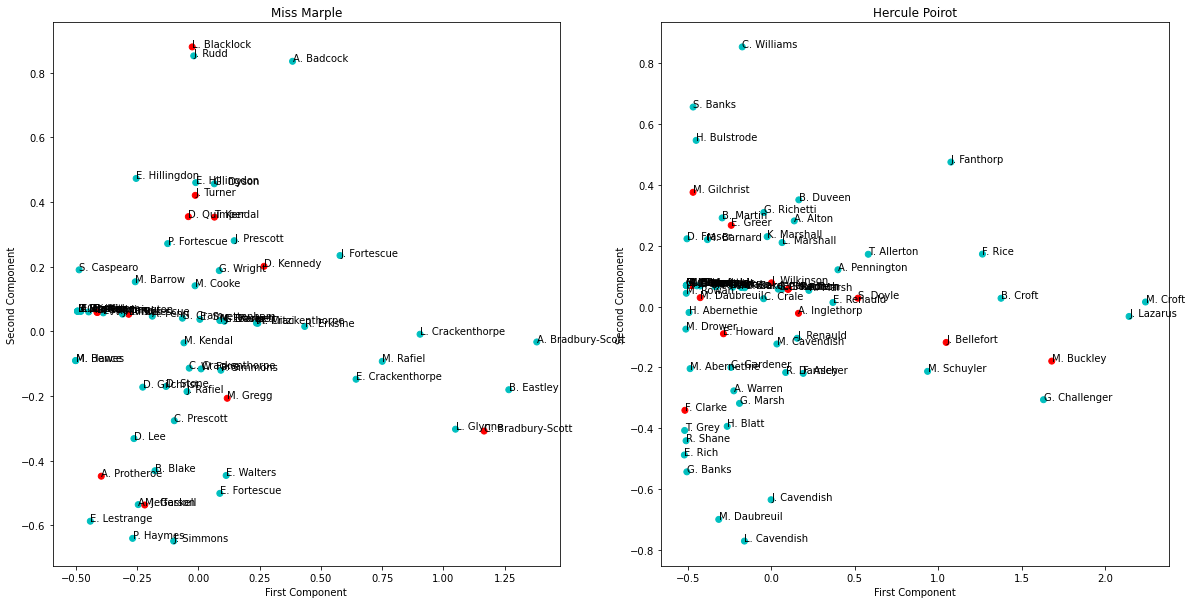

In [32]:
# Get colors based on murderers
marple_colors = marple_df["murderer"]
poirot_colors = poirot_df["murderer"]

pca = PCA(n_components=2)
marple_reduced = pca.fit_transform(marple_df.drop(["murderer"], axis=1)) # Drop "murderer" since that column is only for color
new_marple_df = pd.DataFrame(marple_reduced, 
             columns=["First Component", "Second Component"],
             index=marple_df.index
            )
poirot_reduced = pca.fit_transform(poirot_df.drop(["murderer"], axis=1)) # Drop "murderer" since that column is only for color
new_poirot_df = pd.DataFrame(poirot_reduced, 
             columns=["First Component", "Second Component"],
             index=poirot_df.index
            )

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(new_marple_df["First Component"], new_marple_df["Second Component"], c=marple_colors)
axs[0].set_title("Miss Marple")
axs[0].set_xlabel("First Component")
axs[0].set_ylabel("Second Component")
for i in range(new_marple_df.shape[0]):
    name = new_marple_df.index[i].split()
    label = name[0][0] + ". " + name[-1]
    axs[0].text(new_marple_df["First Component"][i], new_marple_df["Second Component"][i], label)
axs[1].scatter(new_poirot_df["First Component"], new_poirot_df["Second Component"], c=poirot_colors)
axs[1].set_title("Hercule Poirot")
axs[1].set_xlabel("First Component")
axs[1].set_ylabel("Second Component")
for i in range(new_poirot_df.shape[0]):
    name = new_poirot_df.index[i].split()
    label = name[0][0] + ". " + name[-1]
    axs[1].text(new_poirot_df["First Component"][i], new_poirot_df["Second Component"][i], label)

In the above plots, the murderers are labeled in red and the other suspects are in light blue. The plots are created by collecting numerical features regarding each suspect's relationship with the words and actions of the detectives. Specifically, they consider the sentiment scores of text involving both the suspect and the detective, the proximity of the suspect to the detective, the proximity of the suspect to tangible clues mentioned frequently by detectives, and the frequency of the suspect's name. Prior research has demonstrated a relationship between sentiment scores and status as murderer (Siddique). The features are reduced down to 2 using principal component analysis.

In Miss Marple's plot, there is slight clustering of murderers (such as Josie Turner, Dr. Quimper, and Tim Kendal), but no location has all the murderers together. In Poirot's plot, the murderers have approximately segregated, but due to the large span many innocent suspects are close to the murderers. While there is no clear clustering in either case, the mild clumping of characters shows that this analysis is on the right track, and the differences in murderer spread again demonstrate a distinction between the detectives, this time in how they interact with the characters they most suspect.

## Conclusion

This analysis has been successful in demonstrating distinctions between Agatha Christie's detectives Hercule Poirot and Jane Marple. A general overview of the language in the novels of each character prove that a linguistic divide exists between the two groups of novels, and this feature is broken down further by examining distinctions in verb use and sentiment. Drawing on observations from close reading of the texts to recognize the detectives' thought processes produces mixed results, as does quantifying the relationships between the detectives and suspects.

While the lack of clear clustering in the final component could be interpreted as a failure, the clear differences in the cluster shape of murderers is a noteworthy feature because it suggests that the two detectives interact very differently with the suspects that they eventually declare to be the murderers. This, too, serves to compare the detectives, though further feature analysis and more cohesive clustering is necessary to make definite claims. The existing analysis, moreover, fails to account for the last-minute twist that even humans, who can find patterns with greater ease than computer programs, are unable to decipher. The greatness of Christie lies in this, as does the joy derived from consuming her work.

## Works Cited

"About Agatha Christie." *Agatha Christie*, Agatha Christie Limited, www.agathachristie.com/about-christie.

Bargainnier, Earl F. *The Gentle Art of Murder: The Detective Fiction of Agatha Christie*. Bowling Green University Popular Press, 1980.

Siddique, Haroon. "How to Spot Whodunnit: Academics Crack Agatha Christie's Code." *The Guardian*, Guardian News and Media, 2 Aug. 2015, www.theguardian.com/books/2015/aug/02/academics-unlock-formula-agatha-christies-mysteries.